In [ ]:
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-ath12iga
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-ath12iga
  Resolved https://github.com/albumentations-team/albumentations to commit 9eeb60d8d8ca08d5b34700ae2297e616edbb6730
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!git clone https://github.com/MahmudulAlam/TI1K-Dataset.git

fatal: destination path 'TI1K-Dataset' already exists and is not an empty directory.


In [ ]:
# !pip install albucore #==0.0.16

In [ ]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm
import albumentations as A
import glob
from torch import nn
import timm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
with open("/content/TI1K-Dataset/annotation/label.txt", "r") as f:
  labels = f.read()

In [ ]:
labels = labels.split("\n")

In [ ]:
Train_labels = labels[:900]
Test_labels = labels[-100:]
len(Train_labels),len(Test_labels)

(900, 100)

In [ ]:
annots = {}
for label in labels:
  lis = label.split()
  annots[lis[0]] = lis[1:]

In [ ]:
DEVICE = 'cuda'
DATA_DIR = '/content/TI1K-Dataset/'
BATCH_SIZE = 32
IMG_SIZE = 224
LR = 1e-3
EPOCHS = 100
MODEL_NAME = 'efficientnet_b0'

NUM_COR = 4

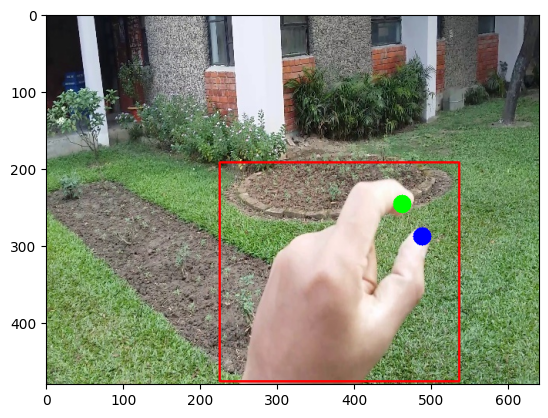

In [ ]:
# [name of the image, xtl, ytl, xbr, ybr, xt, yt, xi, yi]
path = '/content/TI1K-Dataset/train/TI1K_IMAGE_0038.jpg'
img_name = path.split('/')[-1]
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
points = annots[img_name]
# print(points[0])
points = [float(p) for p in points]
h,w,_ = img.shape
pt1 = (int(points[0]*w), int(points[1]*h))
pt2 = (int(points[2]*w), int(points[3]*h))
img = cv2.rectangle(img, pt1, pt2, (255,0,0), 2)
img = cv2.circle(img, (int(points[4]*w), int(points[5]*h)), 12, (0, 0, 255), -10) ##thumb
img = cv2.circle(img, (int(points[6]*w), int(points[7]*h)), 12, (0, 255, 0), -10) ##index
plt.imshow(img);

In [ ]:
h,w,_ = img.shape

train_augs = A.Compose([
                A.Resize(IMG_SIZE, IMG_SIZE),
                # A.HorizontalFlip(p=0.5),
                # A.VerticalFlip(p=0.5),
                # A.Rotate()
], bbox_params=A.BboxParams(format = 'pascal_voc', label_fields=['class_labels']),
                       keypoint_params=A.KeypointParams(format='xy'))

test_augs = A.Compose([
                A.Resize(IMG_SIZE, IMG_SIZE),
                ], bbox_params=A.BboxParams(format = 'pascal_voc', label_fields=['class_labels']),
                keypoint_params=A.KeypointParams(format='xy'))

In [ ]:
train_imgs = glob.glob('/content/TI1K-Dataset/train/*.jpg')
test_imgs = glob.glob('/content/TI1K-Dataset/test/*.jpg')

In [ ]:
labels[0]

'TI1K_IMAGE_0001.jpg 0.14706 0.30719 0.60294 0.88235 0.51961 0.61275 0.46732 0.39379'

In [ ]:
len(test_imgs)

100

In [ ]:
class ObjLocDataset(torch.utils.data.Dataset):

  def __init__(self,labels,sett,augmentations):
    self.annots = labels
    self.augmentations = augmentations
    self.ds = sett

  def __len__(self):
    return len(self.annots)

  def __getitem__(self,idx):
    self.row = self.annots[idx].split()
    self.points = self.row[1:]

    img_path = DATA_DIR + self.ds + '/' + self.row[0]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    h,w,_ = img.shape
    coords = [float(p) for p in self.points]

    x1 = coords[0]
    y1 = coords[1]
    x2 = coords[2]
    y2 = coords[3]
    x3 = coords[4]
    y3 = coords[5]
    x4 = coords[6]
    y4 = coords[7]

    xmin = int(x1*w)
    ymin = int(y1*h)
    xmax = int(x2*w)
    ymax = int(y2*h)

    tx = int(x3*w)
    ty = int(y3*h)
    ix = int(x4*w)
    iy = int(y4*h)

    bbox = [ [xmin, ymin, xmax, ymax]] # Albumentation use this format
    kps = [(tx, ty),(ix, iy)]

    if self.augmentations:
      data = self.augmentations(image = img,bboxes = bbox,keypoints=kps,class_labels=['Hand'])
      img = data['image']
      bbox = data['bboxes']
      kps = data['keypoints']

    img = torch.from_numpy(img).permute(2,0,1) / 255.0  # torch use (channel, height, weight) => shift channel-axis to 0-axis. So (h,w,c)->(c,h,w)
    # print(bbox_kps)

    bbox = torch.Tensor(bbox)
    kps = torch.Tensor(kps)

    bbox_kps = torch.Tensor(list(bbox.flatten()) + list(kps.flatten()))

    # kps = kps.flatten()
    return img,bbox_kps

In [ ]:
trainset =  ObjLocDataset(Train_labels,'train',train_augs)
testset =  ObjLocDataset(Test_labels,'test',test_augs)

In [ ]:
len(trainset),len(testset)

(900, 100)

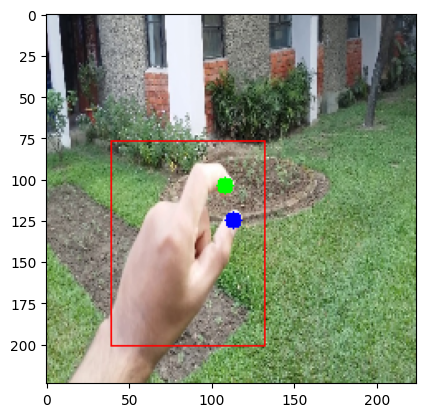

In [ ]:
img,bbox_kps = trainset[7]
x1,y2,x2,y1,x3,y3,x4,y4 = bbox_kps
#  = bbox_kps[1] #[1][0]
# x4,y4 = bbox_kps[1][1]

xmin = int(x1)
ymin = int(y1)
xmax = int(x2)
ymax = int(y2)

# x3,y3,x4,y4 = kps
# x4,y4 = kps[1]

tx = int(x3)
ty = int(y3)
ix = int(x4)
iy = int(y4)

img = img.permute(1, 2, 0).numpy()
img = cv2.rectangle(img, (xmin,ymin), (xmax,ymax), (255,0,0), 1)
img = cv2.circle(img, (tx,ty), 5, (0, 0, 255), -10) ##thumb
img = cv2.circle(img, (ix,iy), 5, (0, 255, 0), -10) ##index
plt.imshow(img);

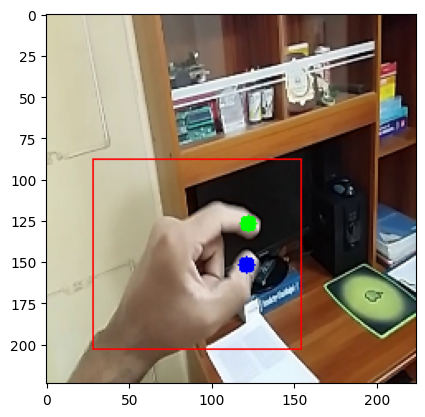

In [ ]:
img,bbox_kps = trainset[777]
x1,y2,x2,y1,x3,y3,x4,y4 = bbox_kps
#  = bbox_kps[1] #[1][0]
# x4,y4 = bbox_kps[1][1]

xmin = int(x1)
ymin = int(y1)
xmax = int(x2)
ymax = int(y2)

# x3,y3,x4,y4 = kps
# x4,y4 = kps[1]

tx = int(x3)
ty = int(y3)
ix = int(x4)
iy = int(y4)

img = img.permute(1, 2, 0).numpy()
img = cv2.rectangle(img, (xmin,ymin), (xmax,ymax), (255,0,0), 1)
img = cv2.circle(img, (tx,ty), 5, (0, 0, 255), -10) ##thumb
img = cv2.circle(img, (ix,iy), 5, (0, 255, 0), -10) ##index
plt.imshow(img);

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(testloader)))

Total no. batches in trainloader : 29
Total no. batches in validloader : 4


In [ ]:
for images,(bboxes) in trainloader:
  break;
print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes and keypoint: {}".format(bboxes.shape))

Shape of one batch images : torch.Size([32, 3, 224, 224])
Shape of one batch bboxes and keypoint: torch.Size([32, 8])


In [ ]:
class ObjLocModel(nn.Module):
  def __init__(self):
    super(ObjLocModel,self).__init__()
    self.efficientnet = timm.create_model(MODEL_NAME, pretrained=True,num_classes=8)

  def forward(self, images, gt_bboxes=None,gt_kps=None):
    bboxes = self.efficientnet(images)

    if gt_bboxes != None:
      loss= nn.MSELoss()(bboxes, gt_bboxes)
      return bboxes,loss

    return bboxes

In [ ]:
model = ObjLocModel()
model.to(DEVICE);

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
def train_fn(model,dataloader,optimizer):
  total_loss = 0.0
  model.train() # train model -> Dropout ON

  # tqdm to track batch
  for data in tqdm(dataloader):
    img,gt_bboxes = data  # gt_bboxes = ground truth
    img,gt_bboxes = img.to(DEVICE),gt_bboxes.to(DEVICE)
    bboxes, loss = model(img, gt_bboxes)  # model predict

    # gradient steps
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

def valid_fn(model,dataloader):
  total_loss = 0.0
  model.eval() # evaluate model -> Dropout OFF

  with torch.no_grad():
    for data in tqdm(dataloader): # tqdm to track batch
      img, gt_bboxes = data
      img, gt_bboxes = img.to(DEVICE), gt_bboxes.to(DEVICE)

      bboxes, loss = model(img, gt_bboxes)
      total_loss += loss.item()

    return total_loss / len(dataloader) # avg loss

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001, threshold_mode='abs')

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer)
  valid_loss = valid_fn(model, testloader)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("Weights are saved")
    best_valid_loss = valid_loss

  scheduler.step(valid_loss)
  print(f"Epoch : {i+1} train loss: {train_loss} valid loss: {valid_loss}")

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Weights are saved
Epoch : 1 train loss: 10435.874747440732 valid loss: 9678.58154296875


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Weights are saved
Epoch : 2 train loss: 6821.270002693966 valid loss: 8318.127685546875


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Weights are saved
Epoch : 3 train loss: 4524.9014682112065 valid loss: 6989.8953857421875


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Weights are saved
Epoch : 4 train loss: 2984.1592554552803 valid loss: 6078.216369628906


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Weights are saved
Epoch : 5 train loss: 1954.9470004377695 valid loss: 5045.7581787109375


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Weights are saved
Epoch : 6 train loss: 1319.9463627256196 valid loss: 4459.001434326172


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Weights are saved
Epoch : 7 train loss: 933.2402585785965 valid loss: 4010.3598022460938


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Weights are saved
Epoch : 8 train loss: 711.2863780054553 valid loss: 3939.840965270996


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Weights are saved
Epoch : 9 train loss: 596.3247065050848 valid loss: 3662.7018661499023


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Weights are saved
Epoch : 10 train loss: 488.3255070653455 valid loss: 3562.6469383239746


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Weights are saved
Epoch : 11 train loss: 436.3848753304317 valid loss: 3444.7295837402344


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Weights are saved
Epoch : 12 train loss: 404.4274055217874 valid loss: 3263.2885551452637


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Weights are saved
Epoch : 13 train loss: 374.6122231319033 valid loss: 3199.226101875305


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Weights are saved
Epoch : 14 train loss: 357.1002814851958 valid loss: 3036.716227531433


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Weights are saved
Epoch : 15 train loss: 348.3702809563998 valid loss: 2913.5459957122803


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Weights are saved
Epoch : 16 train loss: 331.3494714539627 valid loss: 2893.131826400757


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Weights are saved
Epoch : 17 train loss: 416.5886227180218 valid loss: 989.3172760009766


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Weights are saved
Epoch : 18 train loss: 96.85362914512898 valid loss: 191.17229080200195


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Weights are saved
Epoch : 19 train loss: 64.57115857354526 valid loss: 92.68551254272461


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Weights are saved
Epoch : 20 train loss: 41.65838281039534 valid loss: 69.16327333450317


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 21 train loss: 42.967807046298326 valid loss: 71.84208869934082


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Weights are saved
Epoch : 22 train loss: 38.31725771673794 valid loss: 58.77688503265381


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 23 train loss: 32.725313975893215 valid loss: 68.8244104385376


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 24 train loss: 36.24337061520281 valid loss: 85.97154808044434


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Weights are saved
Epoch : 25 train loss: 31.861160672944166 valid loss: 54.94004154205322


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Weights are saved
Epoch : 26 train loss: 39.29279814095333 valid loss: 42.65774345397949


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 27 train loss: 30.962220915432635 valid loss: 56.00699043273926


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Weights are saved
Epoch : 28 train loss: 26.361711173221984 valid loss: 36.298553466796875


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 29 train loss: 33.945177801724135 valid loss: 65.45394515991211


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 30 train loss: 33.82087862080541 valid loss: 49.30740737915039


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 31 train loss: 33.94103675053037 valid loss: 51.87023639678955


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 32 train loss: 29.10666123751936 valid loss: 55.96083974838257


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 33 train loss: 27.98594254460828 valid loss: 43.154590129852295


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 34 train loss: 33.368555923988076 valid loss: 52.621665954589844


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 35 train loss: 33.347402572631836 valid loss: 55.98815870285034


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 36 train loss: 31.57843277372163 valid loss: 56.56483268737793


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 37 train loss: 26.165526784699537 valid loss: 49.573347091674805


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 38 train loss: 30.952186781784583 valid loss: 73.7002124786377


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 39 train loss: 30.850633391018572 valid loss: 44.01569318771362


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 40 train loss: 22.36175379259833 valid loss: 38.51149654388428


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 41 train loss: 23.239761451195026 valid loss: 42.318246841430664


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 42 train loss: 17.446365356445312 valid loss: 40.167691230773926


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 43 train loss: 19.31669623276283 valid loss: 39.506595611572266


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 44 train loss: 17.110868519750134 valid loss: 39.891507148742676


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 45 train loss: 16.867511223102436 valid loss: 38.9864444732666


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 46 train loss: 19.721326268952467 valid loss: 38.59208393096924


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 47 train loss: 21.549417331300933 valid loss: 37.56162357330322


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 48 train loss: 22.610619676524195 valid loss: 45.95310926437378


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 49 train loss: 24.894831361441778 valid loss: 36.65689039230347


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 50 train loss: 22.861846167465735 valid loss: 38.54964256286621


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 51 train loss: 19.14865572699185 valid loss: 36.75517702102661


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 52 train loss: 17.68438717414593 valid loss: 42.000205993652344


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 53 train loss: 19.896589065420216 valid loss: 37.83718013763428


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 54 train loss: 20.575808722397376 valid loss: 40.70015811920166


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 55 train loss: 17.81059610432592 valid loss: 37.112342834472656


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 56 train loss: 19.35058199126145 valid loss: 37.74916124343872


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 57 train loss: 19.943041916551262 valid loss: 38.03271198272705


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 58 train loss: 19.937660118629193 valid loss: 39.68165063858032


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 59 train loss: 19.826767937890416 valid loss: 37.79413604736328


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 60 train loss: 19.007679511760845 valid loss: 37.02979803085327


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 61 train loss: 33.19850410264114 valid loss: 50.08074378967285


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 62 train loss: 19.56131752606096 valid loss: 40.432297706604004


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 63 train loss: 37.95919503836796 valid loss: 48.84057140350342


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 64 train loss: 19.992764242764178 valid loss: 42.98525953292847


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 65 train loss: 18.0991630225346 valid loss: 37.84789228439331


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 66 train loss: 16.974194197819152 valid loss: 36.571391105651855


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Weights are saved
Epoch : 67 train loss: 17.357808178868787 valid loss: 35.854504108428955


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 68 train loss: 15.896614403560244 valid loss: 37.68090057373047


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 69 train loss: 19.01611936503443 valid loss: 39.69230651855469


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 70 train loss: 19.95135652607885 valid loss: 39.4794340133667


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 71 train loss: 17.904530706076788 valid loss: 40.350571632385254


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 72 train loss: 20.316450053247912 valid loss: 37.855929374694824


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 73 train loss: 17.84516245743324 valid loss: 38.00543260574341


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 74 train loss: 18.37520073200094 valid loss: 36.77950620651245


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 75 train loss: 18.65311463125821 valid loss: 40.548760414123535


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 76 train loss: 21.01098195437727 valid loss: 40.13914966583252


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 77 train loss: 23.780715942382812 valid loss: 37.199445724487305


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 78 train loss: 26.585336964705895 valid loss: 43.9820499420166


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 79 train loss: 21.387919064225823 valid loss: 36.78060007095337


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 80 train loss: 20.259116649627686 valid loss: 43.24838161468506


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 81 train loss: 18.159423663698394 valid loss: 36.3918342590332


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 82 train loss: 18.842706285673998 valid loss: 39.18553638458252


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Weights are saved
Epoch : 83 train loss: 21.742585083533978 valid loss: 35.491957664489746


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 84 train loss: 16.96086886833454 valid loss: 37.18089485168457


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 85 train loss: 18.65919642612852 valid loss: 37.615861892700195


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 86 train loss: 18.78037794705095 valid loss: 36.27646446228027


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 87 train loss: 19.518475285891828 valid loss: 35.6547417640686


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 88 train loss: 17.71537601536718 valid loss: 41.99852466583252


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 89 train loss: 20.098703910564556 valid loss: 43.37749004364014


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 90 train loss: 21.212925351899244 valid loss: 41.451316356658936


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 91 train loss: 16.32862449514455 valid loss: 39.32203960418701


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 92 train loss: 18.239712468509016 valid loss: 37.719526290893555


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 93 train loss: 19.92764392392389 valid loss: 35.74307727813721


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 94 train loss: 23.388178266327955 valid loss: 37.32918071746826


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 95 train loss: 15.055679880339524 valid loss: 37.122206687927246


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 96 train loss: 19.852204224158978 valid loss: 39.646180629730225


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 97 train loss: 15.868528398974188 valid loss: 37.43631315231323


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 98 train loss: 14.879279925905426 valid loss: 37.21472883224487


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 99 train loss: 16.995041814343683 valid loss: 37.76364850997925


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 100 train loss: 18.16373029248468 valid loss: 35.75691890716553


In [ ]:
# img,bbox_kps = trainset[555]
# h,w,_ = img.shape

def plot_bbox_kps(img,target,col,tcol,icol,tf=1):
  bbox_kps = list(target.cpu().numpy())
  bbox_kps = [bk.astype(int) for bk in bbox_kps]
  xmin = bbox_kps[0]
  ymin = bbox_kps[1]
  xmax = bbox_kps[2]
  ymax = bbox_kps[3]
  tx = bbox_kps[4]
  ty = bbox_kps[5]
  ix = bbox_kps[6]
  iy = bbox_kps[7]

  if tf==0:
    img = torch.squeeze(img,0)
    img = img.permute(1, 2, 0).numpy()
  img = cv2.rectangle(img, (xmin,ymin), (xmax,ymax), col, 1)
  img = cv2.circle(img, (tx,ty), 4, tcol, -10) ##thumb
  img = cv2.circle(img, (ix,iy), 4, icol, -10) ##index

  return img

In [ ]:
def compare_plots(image,gt_box,out_box):
  col = (255,0,0)
  tcol = (0, 0, 255)
  icol = (0, 255, 0)
  img = plot_bbox_kps(image,gt_box,col,tcol,icol,tf=0)

  col = (255,0,255)
  tcol = (0, 255, 255)
  icol = (255, 255, 0)
  img = plot_bbox_kps(img,out_box,col,tcol,icol)
  plt.imshow(img);

<ipython-input-37-d3f0eb4862ba>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))


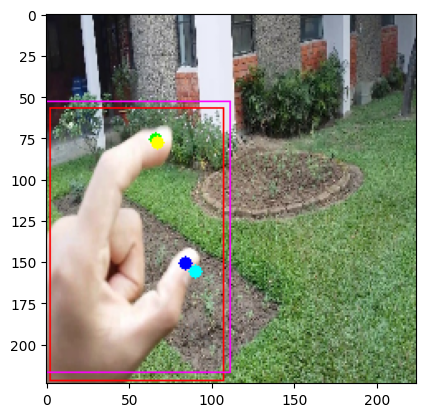

In [ ]:
# device = torch.device('cpu')

# model.load_state_dict(torch.load('best_model.pt',map_location=device))
model.load_state_dict(torch.load('best_model.pt'))

with torch.no_grad():
  image, gt_box = testset[5] # (c,h,w)
  image = image.unsqueeze(0).to(DEVICE) # (batch-size, c, h, w)
  out_bbox = model(image)

  compare_plots(image.cpu(), gt_box, out_bbox[0])

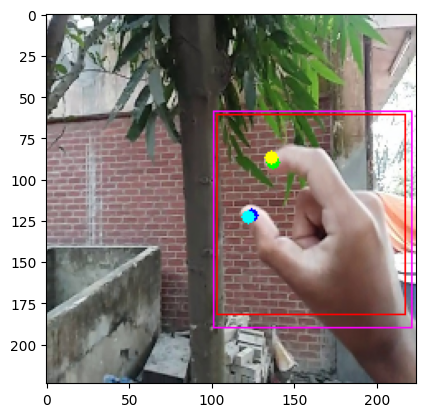

In [ ]:
# model.load_state_dict(torch.load('best_model.pt',map_location=device))

with torch.no_grad():
  image, gt_box = testset[99] # (c,h,w)
  image = image.unsqueeze(0).to(DEVICE) # (batch-size, c, h, w)
  out_bbox = model(image)

  compare_plots(image.cpu(), gt_box, out_bbox[0])

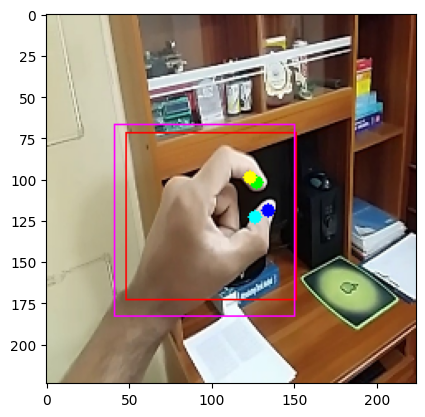

In [ ]:
# model.load_state_dict(torch.load('best_model.pt',map_location=device))

with torch.no_grad():
  image, gt_box = testset[65] # (c,h,w)
  image = image.unsqueeze(0).to(DEVICE) # (batch-size, c, h, w)
  out_bbox = model(image)

  compare_plots(image.cpu(), gt_box, out_bbox[0])

In [ ]:
model_int8 = torch.quantization.quantize_dynamic(
    model,  # the original model
    {torch.nn.Linear, torch.nn.Conv2d, torch.nn.ReLU, torch.nn.BatchNorm2d},
    dtype=torch.qint8)

In [ ]:
torch.save(model_int8.state_dict(), 'EffNet_int8.pt')